In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np

import yfinance as yf

In [2]:
# 시각화 관련 ##
import plotly_express as px
import plotly.figure_factory as ff
import cufflinks as cf
cf.go_offline(connected=True)
## cf.getThemes()
cf.set_config_file(theme='polar')
import plotly.graph_objects as go

import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
## plt.style.use("fivethirtyeight")
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["figure.figsize"] = (10,6)

In [3]:
##절대경로 참조
import sys, os
sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('__file__'))))

from library.quant_functions import anal_funcs, data_funcs

In [6]:
from sklearn.cluster import KMeans

In [55]:
class RoboAdvisor:
    def __init__(self, tickers, start_date, end_date):
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date

    ## Fetching Financial Data
    def fetch_stock_data(self):
            data = yf.download(self.tickers, start=self.start_date, end=self.end_date)['Adj Close']
            return data
    
    ## Preprocessing the Data
    def preprocess_data(self, data):
        daily_returns = data.pct_change().dropna()
        annualized_returns = daily_returns.mean() * 252
        annualized_volatility = daily_returns.std() * np.sqrt(252)
        stock_data = pd.DataFrame({'Returns': annualized_returns, 'Volatility': annualized_volatility})
        stock_data.dropna(inplace=True)  # Drop rows with missing values
        return stock_data
    
    ## Performing K-means Clustering
    def perform_clustering(self, stock_data, num_clusters):
        kmeans = KMeans(n_clusters=num_clusters)
        kmeans.fit(stock_data)
        stock_data['Cluster'] = kmeans.labels_
        stock_data['RRR'] = stock_data['Returns']/stock_data['Volatility']
        return stock_data
    
    ## Generating Portfolio Recommendations
    def generate_portfolio(self, stock_data):
        maxRRR = pd.pivot_table(data=stock_data, index='Cluster', values='RRR', aggfunc='mean')
        maxRRR = maxRRR[maxRRR['RRR']==maxRRR['RRR'].max()].index[0]
        portfolio = stock_data[stock_data['Cluster'] == maxRRR].nlargest(10, 'Returns')
        return portfolio
    
    ## Data Visualization
    def plot_clusters(self, stock_data, portfolio):
        plt.scatter(stock_data['Volatility'], stock_data['Returns'], c=stock_data['Cluster'], cmap='viridis')
        plt.scatter(portfolio['Volatility'], portfolio['Returns'], color='red', marker='x', label='Portfolio')
        plt.xlabel('Volatility')
        plt.ylabel('Returns')
        plt.title('Clustering of Stocks')
        plt.legend()
        plt.show()

    def plot_portfolio(self, stock_data, portfolio):
        plt.scatter(stock_data['Volatility'], stock_data['Returns'], c='lightgray')
        plt.scatter(portfolio['Volatility'], portfolio['Returns'], color='red', marker='x', label='Portfolio')
        plt.xlabel('Volatility')
        plt.ylabel('Returns')
        plt.title('Final Portfolio')
        plt.legend()
        plt.show()

    def plot_sse(self):
        data = self.fetch_stock_data()
        stock_data = self.preprocess_data(data)

        # Perform elbow curve to determine the optimal number of clusters
        sse = []
        for k in range(2, 15):
            kmeans = KMeans(n_clusters=k, n_init=10)
            kmeans.fit(stock_data)
            sse.append(kmeans.inertia_)
        self.sse = sse

        self.stock_data = stock_data

        # Plot the elbow curve
        plt.plot(range(2, 15), sse)
        plt.title("Elbow Curve")
        plt.xlabel("Number of Clusters")
        plt.ylabel("SSE")
        plt.show()



    ## Putting it All Together
    def recommend_portfolio(self, num_clusters):
        stock_data = self.stock_data

        stock_data = self.perform_clustering(stock_data, num_clusters)
        portfolio = self.generate_portfolio(stock_data)
        self.plot_clusters(stock_data, portfolio)
        self.plot_portfolio(stock_data, portfolio)
        print("Recommended Portfolio:")
        print(portfolio)

## Proc

In [56]:
# Define the inputs
dow_jones_url = 'https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average'
dow_jones_table = pd.read_html(dow_jones_url)[1]
dow_jones_tickers = dow_jones_table['Symbol'].tolist()
start_date = '2020-01-01'
end_date = '2023-07-01'

In [57]:
# Create a RoboAdvisor instance and recommend a portfolio
robo_advisor = RoboAdvisor(dow_jones_tickers, start_date, end_date)

[*********************100%***********************]  30 of 30 completed


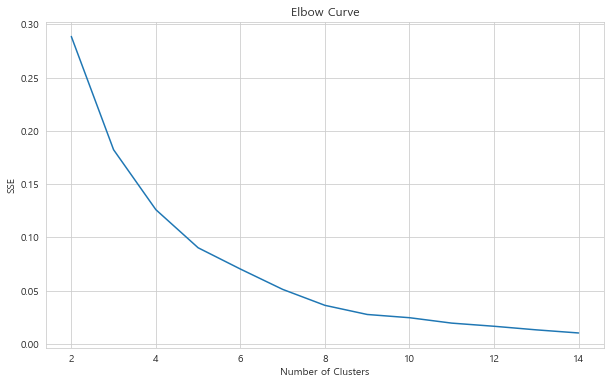

In [58]:
robo_advisor.plot_sse()

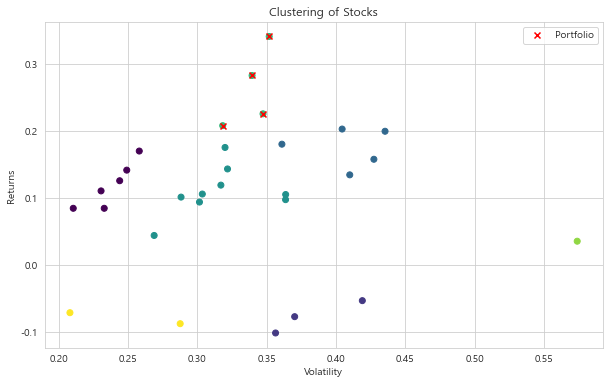

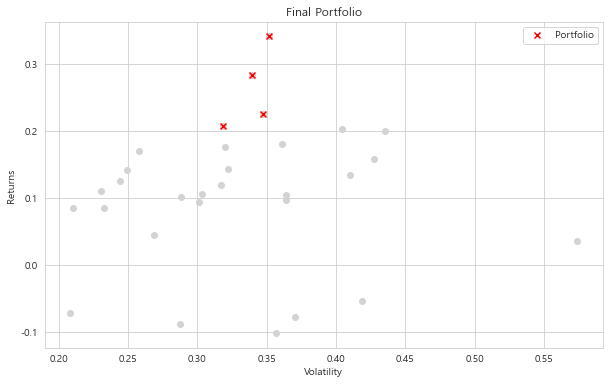

Recommended Portfolio:
       Returns  Volatility  Cluster       RRR
AAPL  0.340720    0.351803        4  0.968495
MSFT  0.282554    0.339465        4  0.832352
CAT   0.225427    0.347336        4  0.649016
UNH   0.207787    0.318289        4  0.652824


In [59]:
robo_advisor.recommend_portfolio(7)